# Opěrná stěna

In [1]:
from __future__ import print_function

import openturns as ot
from openturns.viewer import View
import math as m
from collections import OrderedDict
import re
import matplotlib.pyplot as plt

<img src="zed.png" width=350px>

## Výpočet

Posouzení opěrné stěny na únosnost v základové spáře provedeme podle následujícího postupu a uvedených vzorců. Označení geometrických rozměrů a sil je zřejmé z obrázku.
Stěna je rozdělena na tři geometrické části, pro které vypočítáme vlastní tíhu a polohu těžiště od přední hrany základu (bod P) podle následujících vztahů:
\begin{equation}\nonumber
 G_1 = v b \gamma_{\rm m} \quad G_2 = k \left( h-v \right) \gamma_{\rm m} \quad G_3 = \frac{1}{2}\left( h-v \right)\left( k + \frac{h}{10}\right)\gamma_{\rm m}
\end{equation}

\begin{equation}\nonumber
 G = G_1 + G_2 + G_3
\end{equation}

\begin{equation}\nonumber
 g_1 = \frac{1}{2} b   \quad  g_2 = b - \frac{1}{2} k   \quad  g_3 = b_v + \frac{2}{3}\left( b - b_v -k \right)
\end{equation}

Dále si vypočteme síly od zatížení zeminou, budeme uvažovat pouze aktivní zemní tlak za rubem stěny (pasivní tlak zeminy před konstrukcí stěny zanedbáme). Výslednice horizontálního účinku aktivního zemního tlaku působící na stěnu v jedné třetině výšky $h$:
\begin{equation}\nonumber
 S_{\rm ax} = \frac{1}{2} \gamma_{\rm z} h^2 K_{\rm a} \qquad K_{\rm a} = \tan^2 \left( 45^\circ - \frac{\varphi}{2} \right)
\end{equation}
Výslednice od spojitého přitížení za rubem stěny v jedné polovině výšky $h$:
\begin{equation}\nonumber
 S_{\rm aq} = q K_{\rm a} h
\end{equation}
Svislý účinek zeminy na stěnu:
\begin{equation}\nonumber
 T_{\rm a} = S_{\rm ax} \tan{\delta}  \qquad   \delta = \left( \frac{1}{2} \div  \frac{1}{3} \right) \varphi
\end{equation}
Moment k bodu P působící na stěnu:
\begin{equation}\nonumber
 M_{\rm a} = G_1 g_1 + G_2 g_2 + G_3 g_3  - \frac{1}{3} h S_{\rm ax} - S_{\rm aq} \frac{h}{2} + T_{\rm a} b
\end{equation}
Svislá výslednice působící na základovou zeminu:
\begin{equation}\nonumber
  V = G + T_{\rm a} %H = S_{\rm ax}  \quad
\end{equation}
Efektivní plocha mezi základem a zeminou:
\begin{equation}\nonumber
 A_{\rm ef}=b_{\rm ef} \cdot 1 = (b - 2e)\cdot 1   \quad   e = \frac{1}{2} b - a   \quad  a = \frac{M_{\rm a}}{V}
\end{equation}
Posouzení únosnosti v základové spáře provedeme podle následující nerovnosti:
\begin{equation}\nonumber
 \sigma = \frac{V}{A_{\rm ef}} < R,
\end{equation}
kde $\sigma$ je napětí v základové spáře od zatížení působícího na stěnu, které musí být menší než únosnost základové půdy $R$. Únosnost základové půdy budeme pro zjednodušení uvažovat jako náhodnou veličinu zadanou pomocí pravděpodobnostního rozdělení.


## Náhodné veličiny
Všechny náhodné veličiny jsou uvažovány nezávislé.

|Name              | Distribution      | Mean |  Std | CoV  |  min | max |
| :--------------- |:----------------- | ---- | ---- | ---- | ---- | --- |
| $R$              | Lognormal         | 315  | 37.8 | 0.12 |      |     |
| $\gamma_{\rm m}$ | Normal            |   24 |  1.2 | 0.05 |      |     |
| $q$              | LogNormal         |    4 |  0.4 |  0.1 |      |     |
| $\varphi$        | Truncated Normal  |   33 | 4.95 | 0.15 | 31   | 36  |
| $\gamma_{\rm z}$ | Normal            |   20 |    2 |  0.1 |      |     |

### Vygenerování funkce dosazením všech mezivýpočtů do výsledné rovnice

In [2]:
d = OrderedDict(
    k = '0.8', # sirka na vrcholu steny
    gamma_m = 'gamma_m', # objemova tiha materialu steny
    q = 'q', # spojite zatizeni za stenou
    phi = 'phi', # uhel vnitrniho treni
    gamma_z = 'gamma_z', # objemova tiha zeminy
    
    h = '6.0', # vyska steny
    v = '1.2', # vyska zakladu
    sklon = '5', # sklon lice steny 1:5 az 1:10

    # vypocet pomocnych hodnot pro vypocet napeti
    # v zakladove spare od zemniho tlaku 
    # a spojiteho pritizeni za gravitacni stenou
    bv = '0.5 * v', # sirka predsazeni zakladu
    b = 'k + bv + h / sklon', # sirka zakladu

    G1 = 'v * b * gamma_m',
    G2 = 'k * (h - v) * gamma_m',
    G3 = '1 / 2.0 * (h - v) * (k + h / sklon) * gamma_m',
    G = 'G1 + G2 + G3', # vlastni tiha steny

    # ramena vlastnich tih k bodu P
    g1 = '1 / 2.0 * b',
    g2 = 'b - 1 / 2.0 * k',
    g3 = 'bv + 2 / 3.0 * (b - bv - k)',

    # soucinitel aktivniho zemniho tlaku
    K_a = 'pow((tan((45.0 - 0.5 * phi) / 180.0 * PI)), 2)',

    # sila od zemniho tlaku
    S_ax = '0.5 * gamma_z * pow(h, 2) * K_a',
    S_aq = 'q * K_a * h',

    # zanedbano
    delta = '1/2.0 * phi',# 1/3 az 1/2 * phi 
    T_a = 'S_ax * tan(delta /180. * PI)',


    V = 'G + T_a',
    M = 'G1 * g1 + G2 * g2 + G3 * g3 - S_ax * h / 3.0 - S_aq * h / 2.0 + T_a * b',
    a = 'M / V',
    e = '1 / 2.0 * b - a', # excentricita
    A_ef = 'b - 2.0 * e', # efektivni plocha

    # napeti v zakladove spare
    #sigma_v = 'V / A_ef'
)

sigma_v = 'V / A_ef'

In [3]:
for i in list(d.keys())[::-1]:
    sigma_v = re.sub(r'([ (]+)(%s)([ ),]+)' % i, r'\1(%s)\3' % d.get(i), sigma_v)
    sigma_v = re.sub(r'^%s ' % i, r'(%s) ' % d.get(i), sigma_v)
    sigma_v = re.sub(r' %s$' % i, r' (%s)' % d.get(i), sigma_v)
print(sigma_v)

((((1.2) * ((0.8) + (0.5 * (1.2)) + (6.0) / (5)) * (gamma_m)) + ((0.8) * ((6.0) - (1.2)) * (gamma_m)) + (1 / 2.0 * ((6.0) - (1.2)) * ((0.8) + (6.0) / (5)) * (gamma_m))) + ((0.5 * (gamma_z) * pow((6.0), 2) * (pow((tan((45.0 - 0.5 * (phi)) / 180.0 * PI)), 2))) * tan((1/2.0 * (phi)) /180. * PI))) / (((0.8) + (0.5 * (1.2)) + (6.0) / (5)) - 2.0 * (1 / 2.0 * ((0.8) + (0.5 * (1.2)) + (6.0) / (5)) - ((((1.2) * ((0.8) + (0.5 * (1.2)) + (6.0) / (5)) * (gamma_m)) * (1 / 2.0 * ((0.8) + (0.5 * (1.2)) + (6.0) / (5))) + ((0.8) * ((6.0) - (1.2)) * (gamma_m)) * (((0.8) + (0.5 * (1.2)) + (6.0) / (5)) - 1 / 2.0 * (0.8)) + (1 / 2.0 * ((6.0) - (1.2)) * ((0.8) + (6.0) / (5)) * (gamma_m)) * ((0.5 * (1.2)) + 2 / 3.0 * (((0.8) + (0.5 * (1.2)) + (6.0) / (5)) - (0.5 * (1.2)) - (0.8))) - (0.5 * (gamma_z) * pow((6.0), 2) * (pow((tan((45.0 - 0.5 * (phi)) / 180.0 * PI)), 2))) * (6.0) / 3.0 - ((q) * (pow((tan((45.0 - 0.5 * (phi)) / 180.0 * PI)), 2)) * (6.0)) * (6.0) / 2.0 + ((0.5 * (gamma_z) * pow((6.0), 2) * (pow((t

# Řešení pomocí openturns

In [4]:
dim = 5 # počet náhodných veličin

# parametry vstupních náhodných veličin
mu_gamma_m = 24
cov_gamma_m = 0.05
std_gamma_m = mu_gamma_m * cov_gamma_m

mu_q = 4
cov_q = 0.1
std_q = mu_q * cov_q

mu_phi = 33
cov_phi = 0.15
min_phi = 31
max_phi = 36
std_phi = mu_phi * cov_phi

mu_gamma_z = 20
cov_gamma_z = 0.1
std_gamma_z = mu_gamma_z * cov_gamma_z

mu_R = 315
cov_R = 0.12
std_R = mu_R * cov_R

## Definice rezervy spolehlivosti
### Varianta 1 - čitelnější, ale pomalejší

In [5]:
def regularFunc(x):
    k = 0.8 # sirka na vrcholu steny
    gamma_m = x[0] # objemova tiha materialu steny
    q = x[1] # spojite zatizeni za stenou
    phi = x[2] # uhel vnitrniho treni
    gamma_z = x[3] # objemova tiha zeminy
    R = x[4]
    
    h = 6.0 # vyska steny
    v = 1.2 # vyska zakladu
    sklon = 5 # sklon lice steny 1:5 az 1:10

    # vypocet pomocnych hodnot pro vypocet napeti
    # v zakladove spare od zemniho tlaku 
    # a spojiteho pritizeni za gravitacni stenou
    bv = 0.5 * v # sirka predsazeni zakladu
    b = k + bv + h / sklon # sirka zakladu

    G1 = v * b * gamma_m
    G2 = k * (h - v) * gamma_m
    G3 = 1 / 2.0 * (h - v) * (k + h / sklon) * gamma_m
    G = G1 + G2 + G3 # vlastni tiha steny

    # ramena vlastnich tih k bodu P
    g1 = 1 / 2.0 * b
    g2 = b - 1 / 2.0 * k
    g3 = bv + 2 / 3.0 * (b - bv - k)

    # soucinitel aktivniho zemniho tlaku
    K_a = m.pow((m.tan((45.0 - 0.5 * phi) / 180.0 * m.pi)), 2)

    # sila od zemniho tlaku
    S_ax = 0.5 * gamma_z * m.pow(h, 2) * K_a
    S_aq = q * K_a * h

    # zanedbano
    delta = 1/2.0 * phi# 1/3 az 1/2 * phi 
    T_a = S_ax * m.tan(delta /180. * m.pi)


    V = G + T_a
    M = G1 * g1 + G2 * g2 + G3 * g3 - S_ax * h / 3.0 - S_aq * h / 2.0 + T_a * b
    a = M / V
    e = 1 / 2.0 * b - a # excentricita
    A_ef = b - 2.0 * e # efektivni plocha

    # napeti v zakladove spare
    sigma_v = V / A_ef
    return [R - sigma_v]

limitStatePy = ot.PythonFunction(5, 1, regularFunc)

### Varianta 2 - rychlejší

In [6]:
G = '''R - (((((1.2) * ((0.8) + (0.5 * (1.2)) + (6.0) / (5)) * (gamma_m)) + 
((0.8) * ((6.0) - (1.2)) * (gamma_m)) + 
(1 / 2.0 * ((6.0) - (1.2)) * ((0.8) + (6.0) / (5)) * (gamma_m))) + 
((0.5 * (gamma_z) * 6^2 * ((tan((45.0 - 0.5 * (phi)) / 180.0 * _pi))^2)) * 
tan((1/2.0 * (phi)) /180. * _pi))) / 
(((0.8) + (0.5 * (1.2)) + (6.0) / (5)) - 2.0 * 
(1 / 2.0 * ((0.8) + (0.5 * (1.2)) + (6.0) / (5)) - 
((((1.2) * ((0.8) + (0.5 * (1.2)) + (6.0) / (5)) * (gamma_m)) * 
(1 / 2.0 * ((0.8) + (0.5 * (1.2)) + (6.0) / (5))) + ((0.8) * ((6.0) - (1.2)) * (gamma_m)) * 
(((0.8) + (0.5 * (1.2)) + (6.0) / (5)) - 1 / 2.0 * (0.8)) + 
(1 / 2.0 * ((6.0) - (1.2)) * ((0.8) + (6.0) / (5)) * (gamma_m)) * 
((0.5 * (1.2)) + 2 / 3.0 * (((0.8) + (0.5 * (1.2)) + (6.0) / (5)) - (0.5 * (1.2)) - (0.8))) - 
(0.5 * (gamma_z) * (6.0)^2 * (((tan((45.0 - 0.5 * (phi)) / 180.0 * _pi))^2))) * 
(6.0) / 3.0 - ((q) * (((tan((45.0 - 0.5 * (phi)) / 180.0 * _pi))^2)) * (6.0)) * 
(6.0) / 2.0 + ((0.5 * (gamma_z) * ((6.0)^2) * (((tan((45.0 - 0.5 * (phi)) / 180.0 * _pi))^2))) * 
tan((1/2.0 * (phi)) /180. * _pi)) * ((0.8) + (0.5 * (1.2)) + (6.0) / (5))) / 
((((1.2) * ((0.8) + (0.5 * (1.2)) + (6.0) / (5)) * (gamma_m)) + ((0.8) * ((6.0) - (1.2)) * (gamma_m)) + 
(1 / 2.0 * ((6.0) - (1.2)) * ((0.8) + (6.0) / (5)) * (gamma_m))) + 
((0.5 * (gamma_z) * ((6.0)^2) * (((tan((45.0 - 0.5 * (phi)) / 180.0 * _pi))^2))) * 
tan((1/2.0 * (phi)) /180. * _pi)))))))'''

limitState = ot.Function(['gamma_m', 'q', 'phi', 'gamma_z', 'R'], ['G'], [G])

### Otestování funkcí na středních hodnotách

In [7]:
x = [mu_gamma_m, mu_q, mu_phi, mu_gamma_z, mu_R]
print('x =', x)
print('G(x) =', limitState(x))
print('G(x) =', limitStatePy(x))

x = [24, 4, 33, 20, 315]
G(x) = [156.111]
G(x) = [156.111]


## Definice pravděpodobnostních rozdělení náhodných veličin

In [8]:
gamma_m_dist = ot.Normal(mu_gamma_m, std_gamma_m)
gamma_m_dist.setDescription(['gamma_m'])

q_dist = ot.LogNormalMuSigma(mu_q, std_q).getDistribution()
q_dist.setDescription(['q'])

phi_dist = ot.TruncatedNormal(mu_phi, std_phi, min_phi, max_phi)
phi_dist.setDescription(['phi'])

gamma_z_dist = ot.Normal(mu_gamma_z, std_gamma_z)
gamma_z_dist.setDescription(['gamma_z'])

R_dist = ot.LogNormalMuSigma(mu_R, std_R).getDistribution()
R_dist.setDescription(['R'])

marginals = [gamma_m_dist, q_dist, phi_dist, gamma_z_dist, R_dist]

/home/kelidas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


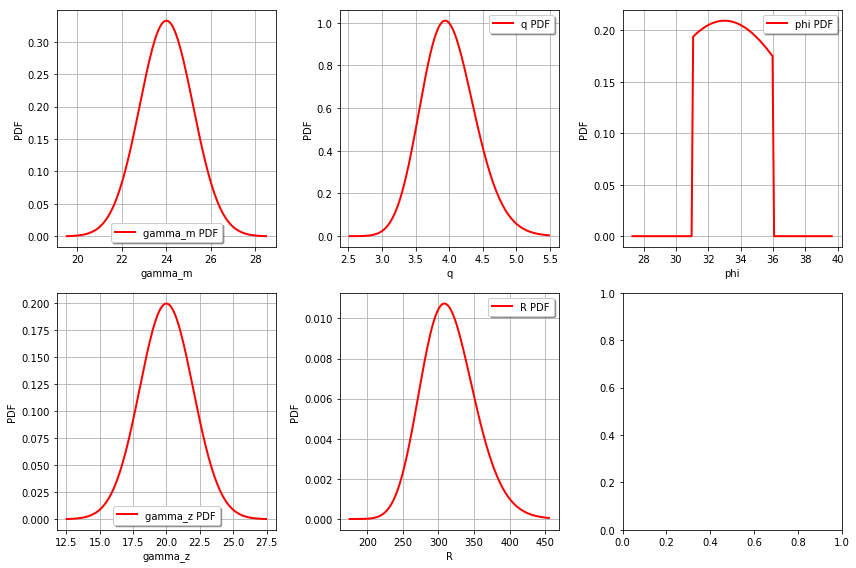

In [9]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12,8), tight_layout=True)
View(gamma_m_dist.drawPDF(), axes=[ax[0, 0]], legend_kwargs=dict(loc='best'))
View(q_dist.drawPDF(), axes=[ax[0, 1]], legend_kwargs=dict(loc='best'))
View(phi_dist.drawPDF(), axes=[ax[0, 2]], legend_kwargs=dict(loc='best'))
View(gamma_z_dist.drawPDF(), axes=[ax[1, 0]], legend_kwargs=dict(loc='best'))
View(R_dist.drawPDF(), axes=[ax[1, 1]], legend_kwargs=dict(loc='best'));

### Sdružené rozdělení pravděpodobnosti

In [10]:
# Create a copula : IndependentCopula (no correlation)
aCopula = ot.IndependentCopula(dim)
aCopula.setName('Independent copula')

# Instanciate one distribution object
myDistribution = ot.ComposedDistribution(marginals, aCopula)
myDistribution.setName('myDist')

In [11]:
RS = ot.CorrelationMatrix(4)
RS[2, 3] = -0.2
# Evaluate the correlation matrix of the Normal copula from RS
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
# Create the Normal copula parametrized by R
copula = ot.NormalCopula(R)

### Náhodné vektory
- $G$ rezerva spolehlivosti
- `myEvent` podmínka spolehlivosti $G < 0$

In [12]:
# We create a 'usual' RandomVector from the Distribution
vect = ot.RandomVector(myDistribution)

# We create a composite random vector
G = ot.RandomVector(limitState, vect) # pro použití varianty 1 limitStatePy

# We create an Event from this RandomVector
myEvent = ot.Event(G, ot.Less(), 0.0)

## Metoda Monte Carlo

In [13]:
cv = 0.05
NbSim = 10000000

experiment = ot.MonteCarloExperiment()
algoMC = ot.ProbabilitySimulationAlgorithm(myEvent, experiment)
algoMC.setMaximumOuterSampling(NbSim)
algoMC.setBlockSize(1)
algoMC.setMaximumCoefficientOfVariation(cv)
# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# Perform the analysis:
algoMC.run()

MonteCarlo result= probabilityEstimate=6.000000e-07 varianceEstimate=5.999996e-14 standard deviation=2.45e-07 coefficient of variation=4.08e-01 confidenceLength(0.95)=9.60e-07 outerSampling=10000000 blockSize=1
Number of executed iterations = 10000000
Number of calls to the limit state = 10000000
Pf =  5.999999999999224e-07
CV = 0.40824816798934055


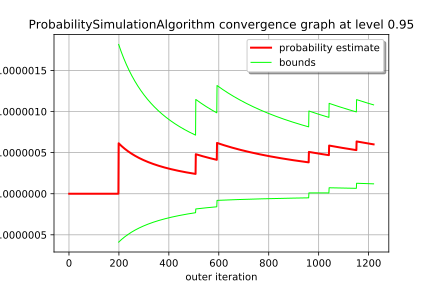

In [14]:
# Results:
resultMC = algoMC.getResult()
probability = resultMC.getProbabilityEstimate()
print('MonteCarlo result=', resultMC)
print('Number of executed iterations =', resultMC.getOuterSampling())
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('Pf = ', probability)
print('CV =', resultMC.getCoefficientOfVariation())
algoMC.drawProbabilityConvergence()

## Metoda FORM - First Order Reliability Method

In [15]:
# Using FORM analysis

# We create a NearestPoint algorithm
myCobyla = ot.Cobyla()
# Resolution options:
eps = 1e-3
niter = 1000

myCobyla.setMaximumIterationNumber(niter)
myCobyla.setMaximumAbsoluteError(eps)
myCobyla.setMaximumRelativeError(eps)
myCobyla.setMaximumResidualError(eps)
myCobyla.setMaximumConstraintError(eps)

# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# We create a FORM algorithm
# The first parameter is a NearestPointAlgorithm
# The second parameter is an event
# The third parameter is a starting point for the design point research

algoFORM = ot.FORM(myCobyla, myEvent, myDistribution.getMean())

# Perform the analysis:
algoFORM.run()

Number of calls to the limit state = 202
beta = 4.691385111913262
Pf = 1.3568081827451706e-06


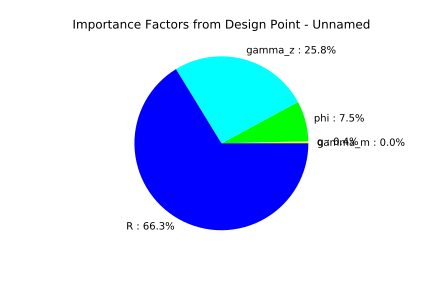

In [16]:
# Results:
resultFORM = algoFORM.getResult()
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('beta =', resultFORM.getHasoferReliabilityIndex())
print('Pf =', resultFORM.getEventProbability())

standardSpaceDesignPoint = resultFORM.getStandardSpaceDesignPoint()

# Graphical result output
resultFORM.drawImportanceFactors()

## Metoda LHS - Latin Hypercube Sampling

In [17]:
cv = 0.05
nsim = 1000000

algoLHS = ot.LHS(myEvent)
algoLHS.setMaximumCoefficientOfVariation(cv)
algoLHS.setMaximumOuterSampling(nsim)
algoLHS.run()

In [18]:
# retrieve results
resultLHS = algoLHS.getResult()
probability = resultLHS.getProbabilityEstimate()

print('Number of calls =', resultLHS.getOuterSampling())
print('CoV=', resultLHS.getCoefficientOfVariation())
print('Pf=', probability)

Number of calls = 1000000
CoV= 0.9999994999998766
Pf= 9.99999999999984e-07


## Metoda Importance Sampling
- pro nalezení oblasti poruchy je využit návrhový bod z metody FORM
- váhová funkce `myImportance` je mnohorozměrné normální rozdělení se směrodatnou odchylkou `impstd` pro všechny dimenze

In [19]:
impstd = 1.0
myImportance = ot.Normal(standardSpaceDesignPoint, [impstd] * dim, ot.CorrelationMatrix(dim))

# Create a simulation algorithm
cv = 0.05
nsim = 10000

experiment = ot.ImportanceSamplingExperiment(myImportance)
algoIS = ot.ProbabilitySimulationAlgorithm(ot.StandardEvent(myEvent), experiment)
algoIS.setMaximumCoefficientOfVariation(cv)
algoIS.setMaximumOuterSampling(nsim)
algoIS.setConvergenceStrategy(ot.Full())
algoIS.run()

In [20]:
# retrieve results
resultIS = algoIS.getResult()
probability = resultIS.getProbabilityEstimate()
print('Number of calls =', resultIS.getOuterSampling())
print('CoV=', resultIS.getCoefficientOfVariation())
print('Pf=', probability)

Number of calls = 2848
CoV= 0.049962492540879935
Pf= 9.449990932684695e-07


## METODA SORM - Second Order Reliability Method

In [21]:
# Using SORM analysis

# We create a NearestPoint algorithm
myCobyla = ot.Cobyla()
# Resolution options:
eps = 1e-3
niter = 1000

myCobyla.setMaximumIterationNumber(niter)
myCobyla.setMaximumAbsoluteError(eps)
myCobyla.setMaximumRelativeError(eps)
myCobyla.setMaximumResidualError(eps)
myCobyla.setMaximumConstraintError(eps)

# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# We create a FORM algorithm
# The first parameter is a NearestPointAlgorithm
# The second parameter is an event
# The third parameter is a starting point for the design point research

algoSORM = ot.SORM(myCobyla, myEvent, myDistribution.getMean())

# Perform the analysis:
algoSORM.run()

Number of calls to the limit state = 263
beta = 4.7540780575392185
Pf = 9.967700552674956e-07
Pf = 9.91610140678596e-07
Pf = 9.859410605475075e-07


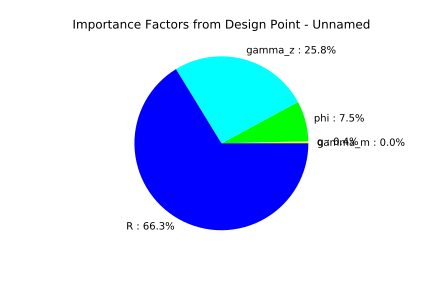

In [22]:
# Results:
resultSORM = algoSORM.getResult()
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('beta =', resultSORM.getGeneralisedReliabilityIndexBreitung())
print('Pf =', resultSORM.getEventProbabilityBreitung())
print('Pf =', resultSORM.getEventProbabilityHohenBichler())
print('Pf =', resultSORM.getEventProbabilityTvedt())

# Graphical result output
resultSORM.drawImportanceFactors()

## Directional sampling

In [23]:
# Using Directional sampling

# Resolution options:
cv = 0.05
NbSim = 100000

algoDS = ot.DirectionalSampling(myEvent)
algoDS.setMaximumOuterSampling(NbSim)
algoDS.setBlockSize(1)
algoDS.setMaximumCoefficientOfVariation(cv)
# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# Perform the analysis:
algoDS.run()

Number of executed iterations = 29205
Number of calls to the limit state = 486372
Pf =  1.057965243875703e-06
CV = 0.049944600661368826


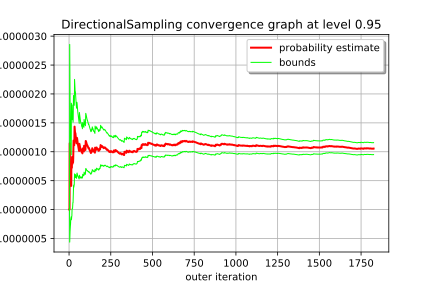

In [24]:
# Results:
resultDS = algoDS.getResult()
probability = resultDS.getProbabilityEstimate()
print('Number of executed iterations =', resultDS.getOuterSampling())
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('Pf = ', probability)
print('CV =', resultDS.getCoefficientOfVariation())
algoDS.drawProbabilityConvergence()